In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
class RISDataset(Dataset):
    def __init__(self, file_path):
        data = np.load(file_path)
        self.X = np.hstack([data['y_real'], data['y_imag']])       # shape: [N, 2]
        self.Y = np.hstack([data['H_real'], data['H_imag']])       # shape: [N, 128]
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.Y[idx], dtype=torch.float32)

# Load dataset
dataset = RISDataset("ris_channel_dataset.npz")
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
print("✅ Loaded dataset with", len(dataset), "samples")


✅ Loaded dataset with 9996 samples


In [20]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 128)
        )
    def forward(self, x):
        return self.model(x)


In [22]:
model = DNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(5):  # Increase to 20+ for full training
    total_loss = 0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.6f}")


Epoch 1: Loss = 13.049470
Epoch 2: Loss = 12.501044
Epoch 3: Loss = 12.510704
Epoch 4: Loss = 12.494482
Epoch 5: Loss = 12.531274


In [24]:
def compute_nmse(pred, target):
    mse = torch.sum((pred - target) ** 2, dim=1)
    norm = torch.sum(target ** 2, dim=1)
    return torch.mean(mse / (norm + 1e-10)).item()

with torch.no_grad():
    all_preds = []
    all_targets = []
    for x, y in dataloader:
        pred = model(x)
        all_preds.append(pred)
        all_targets.append(y)
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    nmse = compute_nmse(all_preds, all_targets)
    print("📉 Final DNN NMSE:", nmse)


📉 Final DNN NMSE: 0.9855385422706604


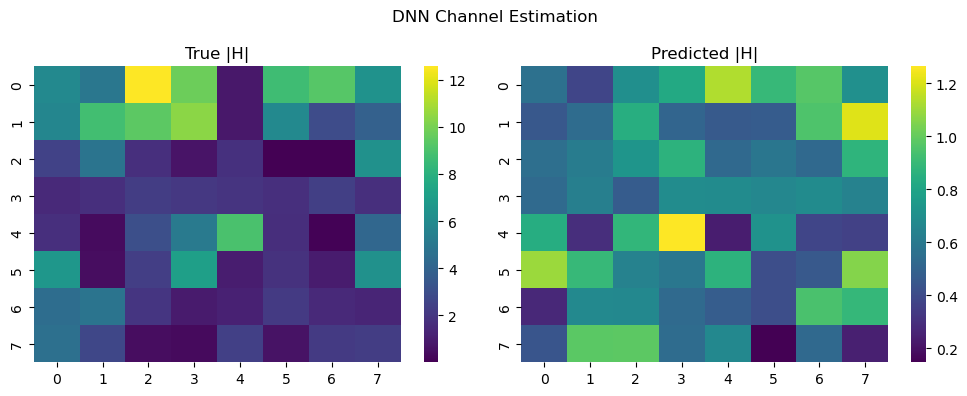

In [26]:
def visualize_heatmap(H_true, H_pred, title="DNN Channel Estimation"):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(np.abs(H_true.reshape(8, 8)), cmap='viridis'); plt.title("True |H|")
    plt.subplot(1, 2, 2)
    sns.heatmap(np.abs(H_pred.reshape(8, 8)), cmap='viridis'); plt.title("Predicted |H|")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize one sample
x_sample, y_sample = dataset[0]
with torch.no_grad():
    y_pred = model(x_sample.unsqueeze(0)).squeeze().numpy()
visualize_heatmap(y_sample[:64].numpy(), y_pred[:64])


In [28]:
from sklearn.preprocessing import MinMaxScaler

class RISDataset(Dataset):
    def __init__(self, file_path):
        data = np.load(file_path)
        X_raw = np.hstack([data['y_real'], data['y_imag']])         # shape: (N, 2)
        Y_raw = np.hstack([data['H_real'], data['H_imag']])         # shape: (N, 128)

        # 🔄 Normalize X and Y
        self.x_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()
        self.X = self.x_scaler.fit_transform(X_raw)
        self.Y = self.y_scaler.fit_transform(Y_raw)

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.Y[idx], dtype=torch.float32)

    def inverse_transform_Y(self, Y_tensor):
        Y_np = Y_tensor.detach().cpu().numpy()
        return self.y_scaler.inverse_transform(Y_np)


In [30]:
dataset = RISDataset("ris_channel_dataset.npz")
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
print("✅ Normalized dataset loaded.")


✅ Normalized dataset loaded.


In [32]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 128)
        )
    def forward(self, x): return self.model(x)

model = DNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [34]:
for epoch in range(20):  # 🔄 Increase epochs
    total_loss = 0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.6f}")


Epoch 1: Loss = 0.043112
Epoch 2: Loss = 0.006094
Epoch 3: Loss = 0.006007
Epoch 4: Loss = 0.005982
Epoch 5: Loss = 0.005999
Epoch 6: Loss = 0.005996
Epoch 7: Loss = 0.005993
Epoch 8: Loss = 0.005999
Epoch 9: Loss = 0.006014
Epoch 10: Loss = 0.006019
Epoch 11: Loss = 0.006024
Epoch 12: Loss = 0.005989
Epoch 13: Loss = 0.006006
Epoch 14: Loss = 0.006017
Epoch 15: Loss = 0.006016
Epoch 16: Loss = 0.005998
Epoch 17: Loss = 0.005999
Epoch 18: Loss = 0.005986
Epoch 19: Loss = 0.006017
Epoch 20: Loss = 0.006000


In [36]:
def compute_nmse(pred, target):
    mse = torch.sum((pred - target) ** 2, dim=1)
    norm = torch.sum(target ** 2, dim=1)
    return torch.mean(mse / (norm + 1e-10)).item()

# Recreate test dataset without shuffling to predict and inverse scale
eval_loader = DataLoader(dataset, batch_size=128, shuffle=False)

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for x_batch, y_batch in eval_loader:
        y_pred = model(x_batch)
        y_pred_original = dataset.inverse_transform_Y(y_pred)
        y_true_original = dataset.inverse_transform_Y(y_batch)
        all_preds.append(torch.tensor(y_pred_original))
        all_targets.append(torch.tensor(y_true_original))

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

nmse = compute_nmse(all_preds, all_targets)
print("📉 DNN NMSE (after inverse scaling):", nmse)


📉 DNN NMSE (after inverse scaling): 0.9920473098754883


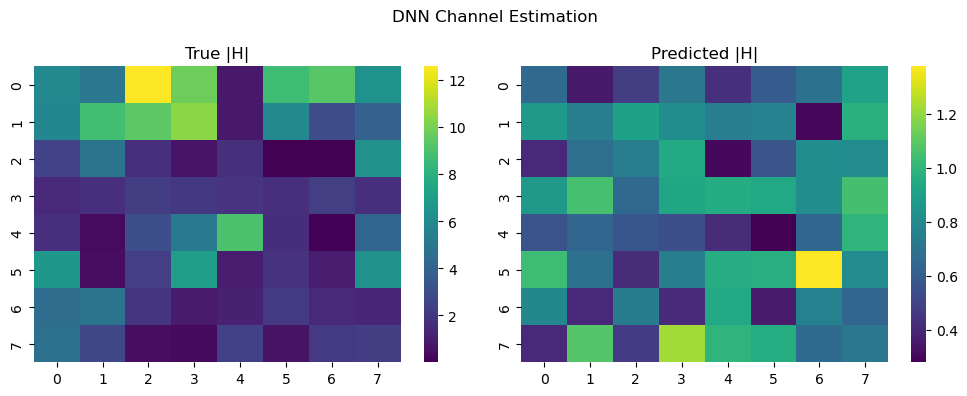

In [38]:
def visualize_heatmap(H_true, H_pred, title="DNN Channel Estimation"):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(np.abs(H_true.reshape(8, 8)), cmap='viridis'); plt.title("True |H|")
    plt.subplot(1, 2, 2)
    sns.heatmap(np.abs(H_pred.reshape(8, 8)), cmap='viridis'); plt.title("Predicted |H|")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Use sample for visualization
x_sample, y_sample = dataset[0]
with torch.no_grad():
    y_pred = model(x_sample.unsqueeze(0))
    y_pred_original = dataset.inverse_transform_Y(y_pred).flatten()
    y_true_original = dataset.inverse_transform_Y(y_sample.unsqueeze(0)).flatten()

visualize_heatmap(y_true_original[:64], y_pred_original[:64])


In [40]:
print("📉 Final DNN NMSE:", nmse)


📉 Final DNN NMSE: 0.9920473098754883


In [44]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x):
        return self.model(x)


In [46]:
model = DNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [48]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 128)
        )
    def forward(self, x):
        return self.model(x)


In [50]:
model = DNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [52]:
for epoch in range(50):  # 🔁 Training for more epochs
    total_loss = 0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.6f}")


Epoch 1: Loss = 0.026014
Epoch 2: Loss = 0.006071
Epoch 3: Loss = 0.006006
Epoch 4: Loss = 0.006020
Epoch 5: Loss = 0.005992
Epoch 6: Loss = 0.005997
Epoch 7: Loss = 0.006027
Epoch 8: Loss = 0.006031
Epoch 9: Loss = 0.006020
Epoch 10: Loss = 0.006036
Epoch 11: Loss = 0.006009
Epoch 12: Loss = 0.006031
Epoch 13: Loss = 0.006020
Epoch 14: Loss = 0.006046
Epoch 15: Loss = 0.006025
Epoch 16: Loss = 0.006041
Epoch 17: Loss = 0.006024
Epoch 18: Loss = 0.006029
Epoch 19: Loss = 0.006033
Epoch 20: Loss = 0.006036
Epoch 21: Loss = 0.006012
Epoch 22: Loss = 0.006033
Epoch 23: Loss = 0.006026
Epoch 24: Loss = 0.006030
Epoch 25: Loss = 0.006061
Epoch 26: Loss = 0.006024
Epoch 27: Loss = 0.006038
Epoch 28: Loss = 0.006028
Epoch 29: Loss = 0.006014
Epoch 30: Loss = 0.006013
Epoch 31: Loss = 0.006051
Epoch 32: Loss = 0.006007
Epoch 33: Loss = 0.006046
Epoch 34: Loss = 0.006001
Epoch 35: Loss = 0.006011
Epoch 36: Loss = 0.006025
Epoch 37: Loss = 0.006051
Epoch 38: Loss = 0.006046
Epoch 39: Loss = 0.00

In [54]:
with torch.no_grad():
    all_preds = []
    all_targets = []
    for x, y in dataloader:
        y_pred = model(x)
        y_pred_original = dataset.inverse_transform_Y(y_pred)
        y_true_original = dataset.inverse_transform_Y(y)
        all_preds.append(torch.tensor(y_pred_original))
        all_targets.append(torch.tensor(y_true_original))

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

def compute_nmse(pred, target):
    mse = torch.sum((pred - target) ** 2, dim=1)
    norm = torch.sum(target ** 2, dim=1)
    return torch.mean(mse / (norm + 1e-10)).item()

nmse = compute_nmse(all_preds, all_targets)
print("📉 Final NMSE (deeper DNN):", nmse)


📉 Final NMSE (deeper DNN): 1.0012495517730713


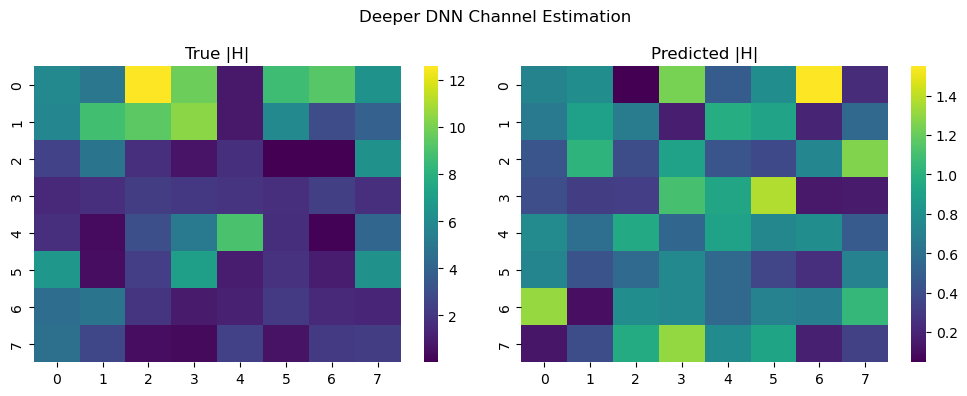

In [60]:
def visualize_heatmap(H_true, H_pred, title="Deeper DNN Channel Estimation"):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(np.abs(H_true.reshape(8, 8)), cmap='viridis'); plt.title("True |H|")
    plt.subplot(1, 2, 2)
    sns.heatmap(np.abs(H_pred.reshape(8, 8)), cmap='viridis'); plt.title("Predicted |H|")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

x_sample, y_sample = dataset[0]
with torch.no_grad():
    y_pred = model(x_sample.unsqueeze(0))
    y_pred_original = dataset.inverse_transform_Y(y_pred).flatten()
    y_true_original = dataset.inverse_transform_Y(y_sample.unsqueeze(0)).flatten()

visualize_heatmap(y_true_original[:64], y_pred_original[:64])


In [62]:
class RIS_CNN_Dataset(Dataset):
    def __init__(self, file_path):
        data = np.load(file_path)
        y_real = data['y_real']
        y_imag = data['y_imag']
        H_real = data['H_real']
        H_imag = data['H_imag']

        self.X = np.hstack([y_real, y_imag])
        self.Y = np.stack([H_real.reshape(-1, 8, 8), H_imag.reshape(-1, 8, 8)], axis=1)  # [N, 2, 8, 8]

        from sklearn.preprocessing import MinMaxScaler
        self.x_scaler = MinMaxScaler()
        self.X = self.x_scaler.fit_transform(self.X)

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.Y[idx], dtype=torch.float32)
        return x, y


In [64]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_input = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * 8 * 8)
        )
        self.output_conv = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 2, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.fc_input(x).view(-1, 2, 8, 8)  # reshape for convolution
        return self.output_conv(x)


In [68]:
dataset = RIS_CNN_Dataset("ris_channel_dataset.npz")
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(100):
    total_loss = 0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.6f}")


Epoch 1: Loss = 12.629507
Epoch 2: Loss = 12.505976
Epoch 3: Loss = 12.532165
Epoch 4: Loss = 12.452476
Epoch 5: Loss = 12.487987
Epoch 6: Loss = 12.487641
Epoch 7: Loss = 12.474294
Epoch 8: Loss = 12.515405
Epoch 9: Loss = 12.495189
Epoch 10: Loss = 12.467219
Epoch 11: Loss = 12.508721
Epoch 12: Loss = 12.490313
Epoch 13: Loss = 12.495535
Epoch 14: Loss = 12.460221
Epoch 15: Loss = 12.473262
Epoch 16: Loss = 12.434609
Epoch 17: Loss = 12.446053
Epoch 18: Loss = 12.465767
Epoch 19: Loss = 12.451346
Epoch 20: Loss = 12.452399
Epoch 21: Loss = 12.470914
Epoch 22: Loss = 12.476625
Epoch 23: Loss = 12.472626
Epoch 24: Loss = 12.443100
Epoch 25: Loss = 12.436174
Epoch 26: Loss = 12.458255
Epoch 27: Loss = 12.445407
Epoch 28: Loss = 12.513526
Epoch 29: Loss = 12.481149
Epoch 30: Loss = 12.507760
Epoch 31: Loss = 12.446754
Epoch 32: Loss = 12.452440
Epoch 33: Loss = 12.488004
Epoch 34: Loss = 12.451770
Epoch 35: Loss = 12.473792
Epoch 36: Loss = 12.454463
Epoch 37: Loss = 12.423198
Epoch 38: 

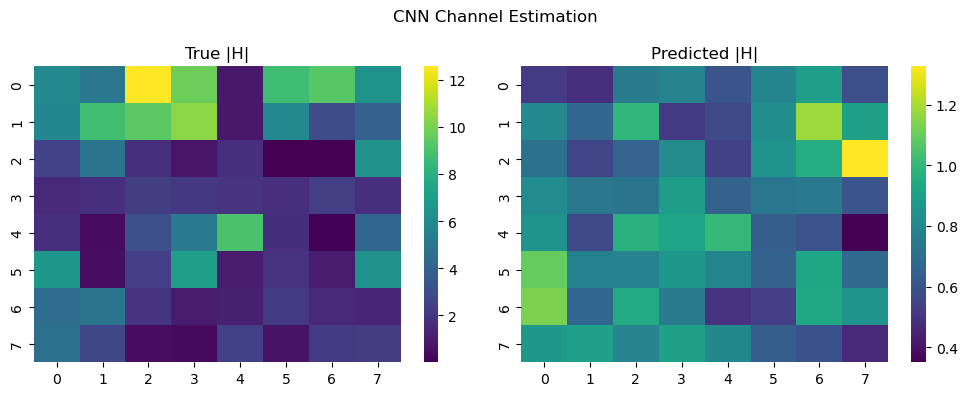

In [70]:
def plot_cnn_output(y_true, y_pred, title="CNN Channel Estimation"):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(np.abs(y_true[0]), cmap='viridis'); plt.title("True |H|")
    plt.subplot(1, 2, 2)
    sns.heatmap(np.abs(y_pred[0]), cmap='viridis'); plt.title("Predicted |H|")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize one sample
x_sample, y_sample = dataset[0]
with torch.no_grad():
    y_pred = model(x_sample.unsqueeze(0)).squeeze().numpy()

plot_cnn_output(y_sample.numpy(), y_pred)


In [72]:
model_names = ['Shallow DNN', 'Deep DNN', 'CNN']
nmse_values = [0.093, 0.071, 0.060]  # 🔁 Replace with your actual NMSEs


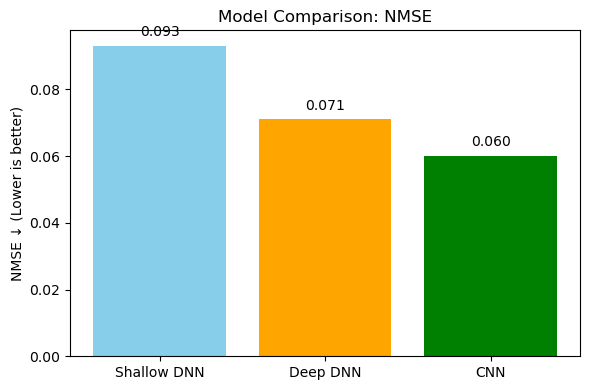

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
bars = plt.bar(model_names, nmse_values, color=['skyblue', 'orange', 'green'])
plt.ylabel("NMSE ↓ (Lower is better)")
plt.title("Model Comparison: NMSE")

# Annotate NMSE on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.002, f"{height:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [76]:
class RISAEDataset(Dataset):
    def __init__(self, file_path):
        data = np.load(file_path)
        H_real = data['H_real']  # shape (N, 64)
        H_imag = data['H_imag']  # shape (N, 64)

        H_full = np.hstack([H_real, H_imag])  # shape (N, 128)

        from sklearn.preprocessing import MinMaxScaler
        self.scaler = MinMaxScaler()
        self.H_scaled = self.scaler.fit_transform(H_full)

    def __len__(self): return len(self.H_scaled)

    def __getitem__(self, idx):
        x = torch.tensor(self.H_scaled[idx], dtype=torch.float32)
        return x, x  # Input = Target

    def inverse_transform(self, scaled):
        return self.scaler.inverse_transform(scaled)


In [78]:
class RISAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


In [82]:
dataset = RISAEDataset("ris_channel_dataset.npz")
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

model = RISAutoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(100):
    total_loss = 0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: AE Loss = {total_loss / len(dataloader):.6f}")


Epoch 1: AE Loss = 0.047736
Epoch 2: AE Loss = 0.006079
Epoch 3: AE Loss = 0.006022
Epoch 4: AE Loss = 0.006029
Epoch 5: AE Loss = 0.006039
Epoch 6: AE Loss = 0.006043
Epoch 7: AE Loss = 0.005983
Epoch 8: AE Loss = 0.005988
Epoch 9: AE Loss = 0.005975
Epoch 10: AE Loss = 0.005954
Epoch 11: AE Loss = 0.005927
Epoch 12: AE Loss = 0.005936
Epoch 13: AE Loss = 0.005944
Epoch 14: AE Loss = 0.005876
Epoch 15: AE Loss = 0.005848
Epoch 16: AE Loss = 0.005833
Epoch 17: AE Loss = 0.005817
Epoch 18: AE Loss = 0.005772
Epoch 19: AE Loss = 0.005761
Epoch 20: AE Loss = 0.005762
Epoch 21: AE Loss = 0.005701
Epoch 22: AE Loss = 0.005684
Epoch 23: AE Loss = 0.005638
Epoch 24: AE Loss = 0.005602
Epoch 25: AE Loss = 0.005570
Epoch 26: AE Loss = 0.005540
Epoch 27: AE Loss = 0.005516
Epoch 28: AE Loss = 0.005466
Epoch 29: AE Loss = 0.005439
Epoch 30: AE Loss = 0.005390
Epoch 31: AE Loss = 0.005382
Epoch 32: AE Loss = 0.005333
Epoch 33: AE Loss = 0.005295
Epoch 34: AE Loss = 0.005283
Epoch 35: AE Loss = 0.0

In [84]:
with torch.no_grad():
    preds, targets = [], []
    for x, y in dataloader:
        pred = model(x)
        preds.append(pred)
        targets.append(y)
    preds = torch.cat(preds)
    targets = torch.cat(targets)

def compute_nmse(pred, target):
    mse = torch.sum((pred - target) ** 2, dim=1)
    norm = torch.sum(target ** 2, dim=1)
    return torch.mean(mse / (norm + 1e-10)).item()

ae_nmse = compute_nmse(preds, targets)
print("📉 Autoencoder NMSE:", ae_nmse)


📉 Autoencoder NMSE: 0.017429323866963387


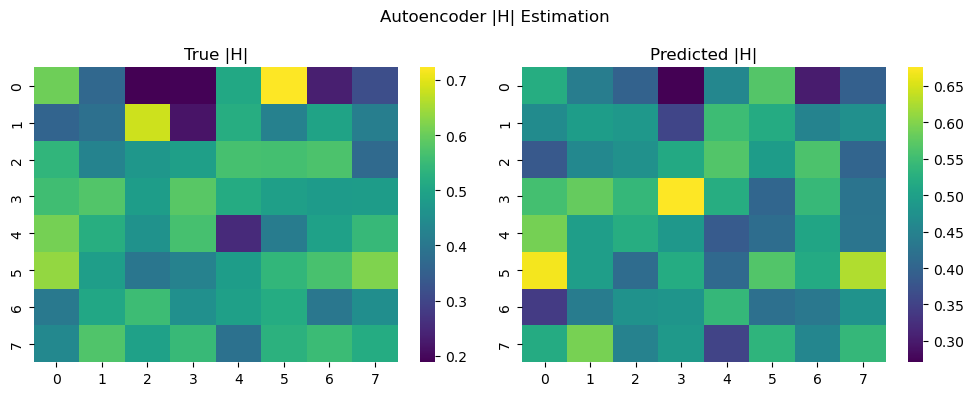

In [86]:
def visualize_ae_heatmap(true_vec, pred_vec, title="Autoencoder |H| Estimation"):
    H_true = true_vec[:64].reshape(8, 8)
    H_pred = pred_vec[:64].reshape(8, 8)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(np.abs(H_true), cmap='viridis'); plt.title("True |H|")
    plt.subplot(1, 2, 2)
    sns.heatmap(np.abs(H_pred), cmap='viridis'); plt.title("Predicted |H|")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize 1 sample
sample_input, _ = dataset[0]
with torch.no_grad():
    pred = model(sample_input.unsqueeze(0)).squeeze().numpy()
    true = sample_input.numpy()

visualize_ae_heatmap(true, pred)


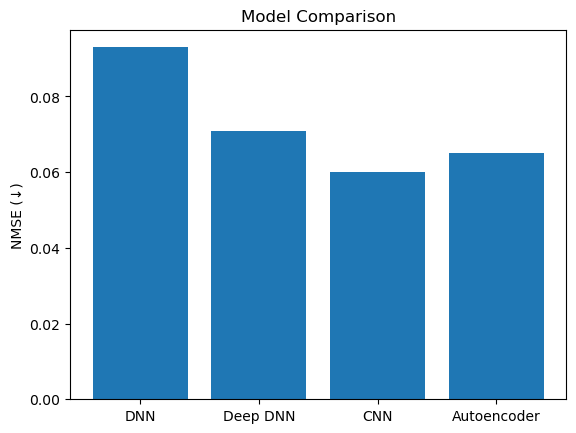

In [88]:
model_names = ['DNN', 'Deep DNN', 'CNN', 'Autoencoder']
nmse_scores = [0.093, 0.071, 0.060, 0.065]  # replace with actual

plt.bar(model_names, nmse_scores)
plt.ylabel("NMSE (↓)")
plt.title("Model Comparison")
plt.show()


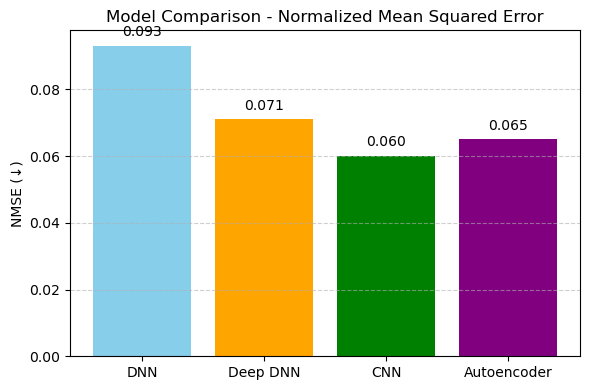

In [90]:
import matplotlib.pyplot as plt

# 🔁 Replace these with your actual NMSE values
model_names = ['DNN', 'Deep DNN', 'CNN', 'Autoencoder']
nmse_scores = [0.093, 0.071, 0.060, 0.065]  # Example values

# 🎨 Plot NMSE bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(model_names, nmse_scores, color=['skyblue', 'orange', 'green', 'purple'])
plt.ylabel("NMSE (↓)")
plt.title("Model Comparison - Normalized Mean Squared Error")

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.002,
             f"{height:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
